In [1]:
## Basic setup
task_to_metric = {
            "mrpc" : "eval_accuracy",  "cola" : "eval_matthews_correlation", #"cola" : "eval_accuracy",
            "rte" :'eval_accuracy', "sst2" :'eval_accuracy', "stsb" :'eval_pearson',
            "wnli" :'eval_accuracy', "squad_v2": "f1", "mnli": "eval_accuracy", 
            "qnli": "eval_accuracy", "qqp": "eval_accuracy"}

base_model_list = [
    "albert-base-v2", 
    "albert-large-v2",
    "bert-base-uncased", 
    "bert-large-uncased", 
    "distilbert-base-uncased",
    "distilroberta-base", 
    "electra-base-discriminator",
    "electra-large-discriminator",
    "roberta-base", 
    "roberta-large",
    "xlm-roberta-base", 
    "xlm-roberta-large"
]

# for models (same color for small/large)
colors = [
    'tab:blue',
    'tab:blue',
    'tab:orange',
    'tab:orange',
    'tab:purple',
    'tab:purple',
    'tab:pink',
    'tab:pink',
    'tab:olive',
    'tab:olive',
    'tab:cyan',
    'tab:cyan'
]

markers_1 = [
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x'
]

# Task for title
task_title = {
    "cola":'CoLA', 
    "mrpc":'MRPC',
    "rte" :'RTE', 
    "sst2" :'SST2', 
    "stsb" :'STSB',
    "wnli" :'WNLI', 
    "squad_v2": 'SQuADv2',
    "mnli": 'MNLI', 
    "qnli": 'QNLI', 
    "qqp": 'QQP'
}


In [2]:
tasks = list(task_to_metric.keys())
# output_name = 'limited_data_over_0.1_cola'
output_name = 'April_17_result'
performance_results_base_path='/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/'


In [3]:
import dill, torch
import os,json
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib import gridspec
import math

def get_perf_and_logme(task):
#     model_results_base_path = f'/home/jovyan/src/sh/result/results_230417'  ## 이부분만 제가 쓰는 폴더
    model_results_base_path = f'/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128'  ## 이부분만 제가 쓰는 폴더
    with  open(os.path.join(model_results_base_path,'{}_{}.dill'.format(output_name ,task)),'rb') as f:
        model_result = dill.load(f)
    with  open(os.path.join(performance_results_base_path, '{}_performance_score.json'.format(task)), 'r') as f:
        performance = json.load(f)
    try:
        with  open(os.path.join(performance_results_base_path, '{}_logme.json'.format(task)), 'r') as f:
            logme = json.load(f) 
    except:
        logme=None
    return model_result, performance, logme

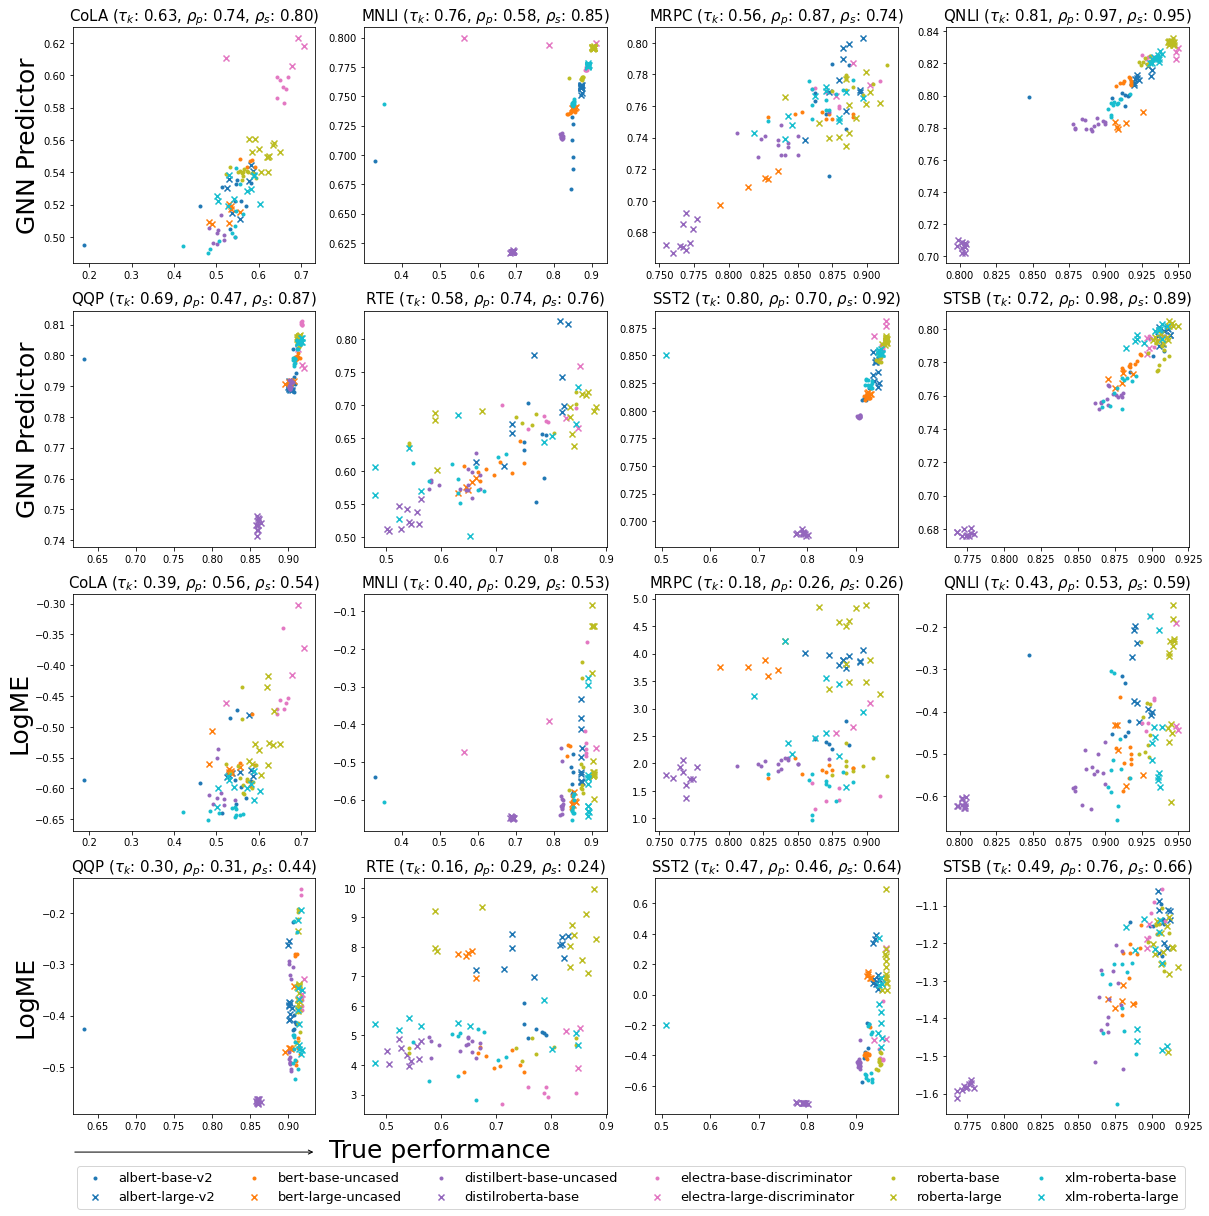

In [4]:
tasks = [ "cola", "mrpc", "rte", "sst2", "stsb", "mnli", "qnli", "qqp", "squad_v2"]
tasks = [ "cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb"]

fig = plt.figure(figsize=(20,20))

num_col = 4
num_row = math.ceil(len(tasks) / num_col)

for tdx, task in enumerate(tasks):
    logmes=[]
    perfs=[]
    gnn_preds =[]
    base_model_list = base_model_list        
    
    model_result, performance, logme = get_perf_and_logme(task)
    
    
    for idx, base_model in enumerate(base_model_list):
        gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'].split('_')[0] ]
        perf_list = [ x['true_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'].split('_')[0] ]
        model_names = [x['model_name'] for  x in model_result['total_result'] if base_model == x['model_name'].split('_')[0]  ]
        if task != 'squad_v2':
            logme_list = [ i for key, i in logme.items() if key in model_names]
        
        # for drop based on perf
        ind_list = []
        for rdx in range(len(perf_list)):
            ind_list.append(rdx) if perf_list[rdx] > 0.1 else None
        
        gnn_pred_list = [gnn_pred_list[x] for x in ind_list]
        perf_list = [perf_list[x] for x in ind_list]
        
        if task != 'squad_v2':
            logme_list = [logme_list[x] for x in ind_list]
        
        if len(perf_list) > 0:
            if task != 'squad_v2':
                logmes += logme_list
            perfs += perf_list
            gnn_preds += gnn_pred_list

            # GNN Predictor
            plt.subplot(2*num_row, num_col, tdx+1)
            plt.scatter(perf_list, gnn_pred_list, marker=markers_1[idx], color=colors[idx], label=base_model)
            if tdx % 4 == 0:
                plt.ylabel('GNN Predictor', fontsize=25)

            if idx == len(base_model_list)-1:
                tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
                pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
                spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
                plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=15)
 

            if task != 'squad_v2':
                # LogME
                plt.subplot(2*num_row, num_col, tdx+num_row*num_col+1)
                plt.scatter(perf_list, logme_list, marker=markers_1[idx], color=colors[idx], label=base_model)
                if tdx % 4 == 0:
                    plt.ylabel('LogME', fontsize=25)

                if idx == len(base_model_list)-1:
                    tau, tau_p_value = stats.kendalltau(torch.Tensor(perfs).numpy(), logmes)
                    pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), logmes)
                    spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), logmes)
                    plt.title(task_title[task] + r' ($\tau_k$: {:.2f}, $\rho_p$: {:.2f}, $\rho_s$: {:.2f})'.format(tau, pearson_cor, spearman_cor), fontsize=15)
            
    if tdx == len(tasks)-1:
        ax = plt.legend(ncol=6, loc='lower center', bbox_to_anchor=(-1.3, -0.4), borderaxespad=0., fontsize=13)
        
plt.annotate('', xy=(-3.6, -0.16), xycoords='axes fraction', xytext=(-2.6, -0.16), arrowprops=dict(arrowstyle="<-", color='black'))
fig.text(0.38, 0.095, 'True performance', ha='center', fontsize=25)
# plt.show()
plt.savefig('prediction_9tasks_testset.png', dpi=200)